# EE6934 Group 1
### This notebook contains the code for:
* training "Simple Conv Upsampling" + EfficientDet on VOC2007
* evaluating EfficientDet on original VOC2007, and VOC2007 processed by SRGAN

In [12]:
import os
import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    sys.path.remove(path)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import VOCDetection, Normalizer, Augmenter, collater, get_augumentation, VOC_CLASSES#,Resizer
import importlib
import models
import utils
import train
import copy
import datetime
from tqdm import tqdm

### Helper Functions

In [13]:
def show_data(ori):
    """Plot image tensors directly"""
    img = ori.squeeze().cpu().detach().numpy()
    img = normalize_npimg(img)
    plt.imshow(img[:,:,(0,1,2)])
    
def normalize_npimg(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

class Resizer(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample, common_size=512):
        image, annots = sample['img'], sample['annot']
        height, width, _ = image.shape
        if height > width:
            scale = common_size / height
            resized_height = common_size
            resized_width = int(width * scale)
        else:
            scale = common_size / width
            resized_height = int(height * scale)
            resized_width = common_size
        
        image = cv2.resize(image, (resized_width, resized_height))
         
        """downsample then bicubic upsample"""
#         image = cv2.resize(image, (int(resized_width/4), int(resized_height/4)))
#         image = cv2.resize(image, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
        
        new_image = np.zeros((common_size, common_size, 3))
        new_image[0:resized_height, 0:resized_width] = image
        annots[:, :4] *= scale
        return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}

In [17]:
class args():
    network = 'efficientdet-d0'
    threshold = 0.5
    iou_threshold = 0.6
    dataset = 'VOC'
    num_class = 20    
    lr = 1e-4
    batch_size = 8
    start_epoch = 0
    num_epoch = 360
    grad_accumulation_steps = 1
    resume = '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/checkpoints/VOC/efficientdet-d0/upsampling_checkpoint_e81_19:04_16Apr2020.pth'
    save_folder = 'checkpoints'

You'll need to install VOC2007 in a VOCdevkit directory, as per the default installation instruction.
<br> Modify `root` to the VOCdevkit directory

In [18]:
root="/media/sf/61CEC7C06EDB83CC/VOCdevkit"

train_dataset = VOCDetection(root=root, image_sets=[('2007', 'train')], transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
valid_dataset = VOCDetection(root=root, image_sets=[('2007', 'val')], transform=transforms.Compose([Normalizer(), Resizer()]))
test_dataset = VOCDetection(root,image_sets=[('2007', 'test')],transform=transforms.Compose([Normalizer(), Resizer()]))

test_loader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=False, collate_fn=collater, pin_memory=False)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=2, shuffle=True, collate_fn=collater, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=False, collate_fn=collater, pin_memory=False)

In [16]:
# SR_test_dataset = VOCDetection(root,image_sets=[('2007SR', 'test')],transform=transforms.Compose([Normalizer(), Resizer()]))
# SR_test_loader = DataLoader(SR_test_dataset, batch_size=1, num_workers=6, shuffle=False, collate_fn=collater, pin_memory=False)

### This will load the "Simple conv upsampling model" prepended to EfficientDet

In [6]:
# Load existing checkpoint
importlib.reload(models)
importlib.reload(utils)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = []
if(args.resume is not None):
    print("Loading: '{}'".format(args.resume))
    checkpoint = torch.load(args.resume, map_location=device)
    params = checkpoint['parser']
    args.num_class = params.num_class
    args.network = params.network
    args.start_epoch = checkpoint['epoch'] + 1
    del params

model = models.EfficientDet_up(num_classes=args.num_class, network=args.network,
                     W_bifpn=utils.EFFICIENTDET[args.network]['W_bifpn'],
                     D_bifpn=utils.EFFICIENTDET[args.network]['D_bifpn'],
                     D_class=utils.EFFICIENTDET[args.network]['D_class'])

if(args.resume is not None):
    model.load_state_dict(checkpoint['state_dict'], strict=False)
del checkpoint
model = model.to(device);

# freeze all layers except for the convs
for i, (name, param) in enumerate(model.named_parameters()):
    if i < 15:
        param.requires_grad = True
    else:
        param.requires_grad = False

### Use this to start or resume training

In [20]:
# for training
importlib.reload(train)

optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(args.start_epoch, args.num_epoch):
    train.train(train_loader, model, scheduler, optimizer, epoch, args)
    if (epoch+1) % 10 == 0:
        train.test(valid_dataset, model, epoch, args)

    state = { 'epoch': epoch, 'parser': args, 'state_dict': utils.get_state_dict(model)}
    
    timestamp = datetime.datetime.now().strftime("%H:%M_%d%b%Y")
    torch.save(state,
        os.path.join(args.save_folder,"VOC",args.network,
            "upsampling_checkpoint_e{}_{}.pth".format(epoch,timestamp)))

hi from train.py
82 epoch: 	 start training....


KeyboardInterrupt: 

---
### mAP calculation
this will evaluate the `model` defined above on the VOC2007 test dataset

In [20]:
train.test(test_dataset, model, 0, args)

0 epoch: 	 start validation....
len of dataset: 4952, current: 0
len of dataset: 4952, current: 1000
len of dataset: 4952, current: 2000
len of dataset: 4952, current: 3000
len of dataset: 4952, current: 4000
4952/4952
mAP:
aeroplane: 0.5738842901709384
bicycle: 0.5348080664104735
bird: 0.36197037093859596
boat: 0.30717045173408375
bottle: 0.2170611944820144
bus: 0.6010484427235094
car: 0.6598025774101475
cat: 0.5133826828070354
chair: 0.2779951644093994
cow: 0.4270290765994831
diningtable: 0.4690248661360016
dog: 0.4924387280965312
horse: 0.6371760141325031
motorbike: 0.6069153019226949
person: 0.6623063053452731
pottedplant: 0.2187999150728551
sheep: 0.44597668786921096
sofa: 0.52686766902202
train: 0.6208301726360039
tvmonitor: 0.5218102023773341
avg mAP: 0.4838149090148054


Some test results
* normal mAP: **0.5896**
* 4x bicubic mAP: **0.3780**
* upsampling convs + pixel shuffle (131epochs): **0.4838**

---

### Single frame Testing

In [21]:
class Detect(object):
    def __init__(self, weights, up=False, num_class=20, network='efficientdet-d0', size_image=(512,512)): #(512,512)
        super(Detect,  self).__init__()
        self.weights = weights
        self.size_image = size_image
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else 'cpu')
        self.transform = get_augumentation(phase='test')
        if(self.weights is not None):
            print('Load pretrained Model')
            checkpoint = torch.load(
                self.weights, map_location=lambda storage, loc: storage)
            params = checkpoint['parser']
            num_class = params.num_class
            network = 'efficientdet-d0'#params.network
        if up:
            self.model = models.EfficientDet_up(num_classes=num_class,network=network,
                                                W_bifpn=utils.EFFICIENTDET[network]['W_bifpn'],
                                                D_bifpn=utils.EFFICIENTDET[network]['D_bifpn'],
                                                D_class=utils.EFFICIENTDET[network]['D_class'],is_training=False)
        else:
            self.model = models.EfficientDet(num_classes=num_class,network=network,
                                             W_bifpn=utils.EFFICIENTDET[network]['W_bifpn'],
                                             D_bifpn=utils.EFFICIENTDET[network]['D_bifpn'],
                                             D_class=utils.EFFICIENTDET[network]['D_class'],is_training=False)

        if(self.weights is not None):
            state_dict = checkpoint['state_dict']
            self.model.load_state_dict(state_dict, strict=False)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.model.eval()

    def process(self, threshold, iou_threshold, file_name=None, img=None, show=False):
        if file_name is not None:
            img = cv2.imread(file_name)
        origin_img = copy.deepcopy(img)
        augmentation = self.transform(image=img)
        img = augmentation['image']
        img = img.to(self.device)
        img = img.unsqueeze(0)

        with torch.no_grad():
            scores, classification, transformed_anchors = self.model(img)
            
            # filter by score
            transformed_anchors = transformed_anchors[scores > threshold]
            scores = scores[scores > threshold]
            classification = scores[[scores > threshold]]

            # NMS
            keep_nms = torchvision.ops.nms(transformed_anchors, scores, iou_threshold)
            transformed_anchors = transformed_anchors[keep_nms]
            
            bboxes = list()
            labels = list()
            bbox_scores = list()
            colors = list()
            for j in range(transformed_anchors.shape[0]):
                bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
                x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
                y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
                x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
                y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
                bboxes.append([x1, y1, x2, y2])
                label_name = VOC_CLASSES[int(classification[[j]])]
                labels.append(label_name)

                if args.score:
                    score = np.around(
                        scores[[j]].cpu().numpy(), decimals=2) * 100
                    bbox_scores.append(int(score))
            if show:
                origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
                fig, ax = utils.vis_bbox(img=origin_img, bbox=bboxes,
                                   label=labels, score=bbox_scores)
#                 fig.savefig('./docs/demo.png')
                plt.show()
            else:
                return origin_img

In [130]:
args.file_name = None#"./demo.png"
args.img = np.array(normalize_npimg(test_dataset.__getitem__(300)['img'].float().numpy())*255, dtype=np.uint8)[:,:,(2,1,0)]
args.weight = './checkpoint_VOC_efficientdet-d0_268.pth'
args.score=True

Load pretrained Model
Loaded pretrained weights for efficientnet-b0


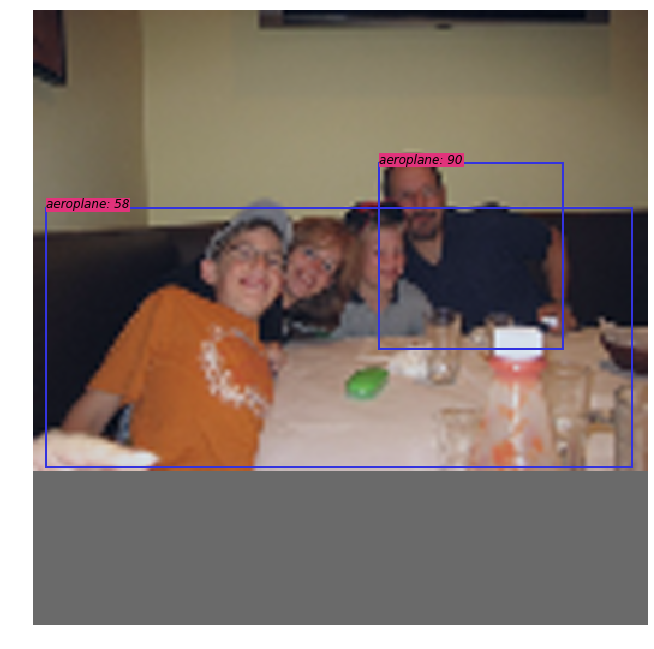

In [131]:
detect = Detect(weights=args.weight, up=False)
detect.process(args.threshold, args.iou_threshold, file_name=args.file_name, img=args.img, show=True)